### Setting up FourRooms

In [7]:
from deep_rl.component.fourrooms import *

In [8]:
env = FourRoomsMatrix()
state = env.reset()
# plt.subplot(121), plt.imshow(state.reshape((13,13)))
# action = env.action_space.sample()
# state, reward, done, info = env.step(action)
# print(reward, done, info)
# plt.subplot(122), plt.imshow(state.reshape((13,13))); plt.show()
# print(action)

In [9]:
env.observation_space

Box(169,)

### Run DQN on 4 rooms

In [28]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [43]:
game = 'FourRoomsMatrix'
agent = dqn_feature(game=game)

2020-05-08 03:53:36,917 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-08 03:53:42,960 - root - INFO: steps 5000, episodic_return_test -140.60(28.69)
2020-05-08 03:53:49,221 - root - INFO: steps 10000, episodic_return_test -180.30(18.69)
2020-05-08 03:53:55,413 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-05-08 03:54:01,535 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-05-08 03:54:07,885 - root - INFO: steps 25000, episodic_return_test -180.50(18.50)
2020-05-08 03:54:14,775 - root - INFO: steps 30000, episodic_return_test -180.30(18.69)
2020-05-08 03:54:21,865 - root - INFO: steps 35000, episodic_return_test -102.50(30.84)
2020-05-08 03:54:28,976 - root - INFO: steps 40000, episodic_return_test -100.90(31.34)
2020-05-08 03:54:36,024 - root - INFO: steps 45000, episodic_return_test -44.00(24.69)
2020-05-08 03:54:42,949 - root - INFO: steps 50000, episodic_return_test -6.80(1.20)


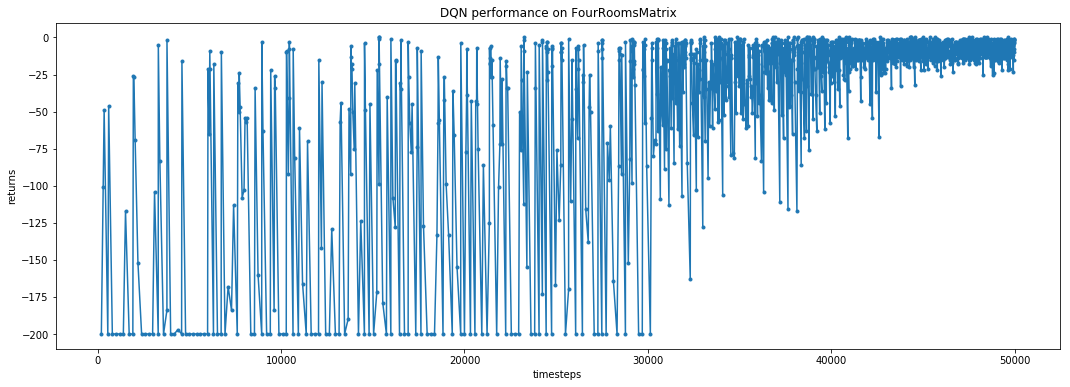

(Text(0.5,1,'DQN performance on FourRoomsMatrix'), None)

In [47]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

### ROUGH BELOW

In [10]:
"""
Adopted from https://github.com/alversafa/option-critic-arch/blob/master/fourrooms.py.

Modified to return one hot encoded states and gym compatible.

"""

import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class FourRoomsMatrix(gym.Env):

    def __init__(self, goal=62, p=0, config=2):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.p = p # Stocasticity the environment
        self.config = config
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # Four possible actions
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))
        self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        self.action_space = spaces.Discrete(4)
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

        # Random number generator
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}


        self.goal = goal # East doorway
        self.init_states = list(range(self.obs_space.shape[0]))
        self.init_states.remove(self.goal)
        self.updates = 0
        self.horizon = 200


    def render(self, show_goal=True):
        current_grid = np.array(self.occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = -1
        if show_goal:
            goal_cell = self.tocell[self.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -2
        return current_grid

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        state = self.rng.choice(self.init_states)
        # state = 0 # fix starting state
        self.current_cell = self.tocell[state]
        if(self.config == 0):
            return state
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            self.updates = 0
            return temp
        elif(self.config == 2):
            return env.render()
        else:
            raise
            

    def check_available_cells(self, cell):
        available_cells = []

        for action in range(len(self.a_space)):
            next_cell = tuple(cell + self.directions[action])

            if not self.occupancy[next_cell]:
                available_cells.append(next_cell)

        return available_cells
        

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]

            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        # When goal is reached, it is done
        done = state == self.goal

        if(done):
            reward = 0
        else:
            reward = -1

        if(self.updates>=self.horizon):
            reward = -1
            done = True

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return env.render, reward, done, {}

        